In [2]:
using Pkg
Pkg.activate("/Users/ryansenne/Documents/GitHub/SSM")

include("/Users/ryansenne/Documents/GitHub/SSM//src/SSM.jl")
using .SSM
using LinearAlgebra
using Random
using Distributions
using Plots
using CSV
using DataFrames
using BenchmarkTools

  Activating project at `\Users\ryansenne\Documents\GitHub\SSM`


In [2]:
# Generate data from a known dynamical system--a pendulum
g = 9.81 # gravity
l = 1.0 # length of pendulum
dt = 0.001 # time step
T = 10 # total time
# Discrete-time dynamics
A = [1.0 dt; -g/l*dt 1.0]
# Initial state
x0 = [0.0; 1.0]
# Time vector
t = 0:dt:T
# Generate data
x = zeros(2, length(t))
x[:,1] = x0
for i = 2:length(t)
    x[:,i] = A*x[:,i-1]
end

# Now lets add noise to the system and see if we can recover the dynamics
# Add driving Gaussian noise to simulate observations
x_noisy = zeros(2, length(t))
x_noisy[:, 1] = x0
observation_noise_std = 0.5

noise = rand(Normal(0, observation_noise_std), (2, length(t)))

for i in 2:length(t)
    x_noisy[:, i] = A * x[:, i-1] + noise[:, i]
end

# Define the LDS model parameters
H = I(2)  # Observation matrix (assuming direct observation)
Q = 1e-8 * I(2)  # Process noise covariance
R = 0.25 * I(2)  # Observation noise covariance
P0 = 1e-2 * I(2)  # Initial state covariance
x0 = [0.0; 1.0]  # Initial state mean

# Create the Kalman filter parameter vector
kf = LDS(A, Matrix{Float64}(H), nothing, Matrix{Float64}(Q), Matrix{Float64}(R), x0, Matrix{Float64}(P0), nothing, 2, 2, Vector([true, true, false, true, true, true, true, false]))


LDS([1.0 0.001; -0.009810000000000001 1.0], [1.0 0.0; 0.0 1.0], nothing, [1.0e-8 0.0; 0.0 1.0e-8], [0.25 0.0; 0.0 0.25], [0.0, 1.0], [0.01 0.0; 0.0 0.01], nothing, 2, 2, Bool[1, 1, 0, 1, 1, 1, 1, 0])

In [5]:
x_smooth, P_smooth = KalmanSmoother(kf, Matrix{Float64}(x_noisy'))

([1.5859203084936365e-5 0.9886961992032222; 0.001004555303456802 0.9886960318685859; … ; -0.03572302586785606 1.0367177775414145; -0.03468631111950447 1.0370681696225783], [1.595514254043584e-5 4.300000760954962e-6; 1.5953927259752462e-5 4.294891123475896e-6; … ; 1.645113254409217e-5 -4.496213856714466e-6; 1.6452296895962873e-5 -4.499459631246881e-6;;; 4.300000760954962e-6 0.0001514420272736277; 4.294891123475896e-6 0.00015134951160912166; … ; -4.496213856714466e-6 0.00015809536791041011; -4.499459631246895e-6 0.0001581951541639029], [0.9999891500370034 0.009809884399661826; 0.9999891097855808 0.00980987449077116; … ; 0.9993776706292378 0.009786471583155987; 1.0 1.0;;; -0.0009999983122381782 0.9999891500370031; -0.0010000077862088522 0.9999891099836632; … ; -0.0010173497168913387 0.999926351174421; 1.0 1.0], -14642.316987596143)

In [6]:
# calculate the predictions of X
x_prediction = zeros(length(t), 2)
x_prediction[1, :] = kf.x0
for t in 2:length(t)
    x_prediction[t, :] = kf.A * x_prediction[t-1, :]
end

x_new = SSM.newton_raphson_tridg!(kf, x_prediction, x_noisy', 10, 1e-3)

Norm of gradient iterate difference: 0.6884355209737434
Converged at iteration 2


10001×2 Matrix{Float64}:
  1.58592e-5  0.988696
  0.00100456  0.988696
  0.00199327  0.988686
  0.002982    0.988667
  0.00397068  0.988637
  0.00495931  0.988598
  0.00594788  0.98855
  0.00693637  0.988491
  0.00792484  0.988423
  0.00891325  0.988345
  ⋮           
 -0.0429694   1.03398
 -0.0419354   1.0344
 -0.040901    1.03481
 -0.0398661   1.03521
 -0.0388309   1.03561
 -0.0377953   1.03599
 -0.0367594   1.03636
 -0.035723    1.03672
 -0.0346863   1.03707

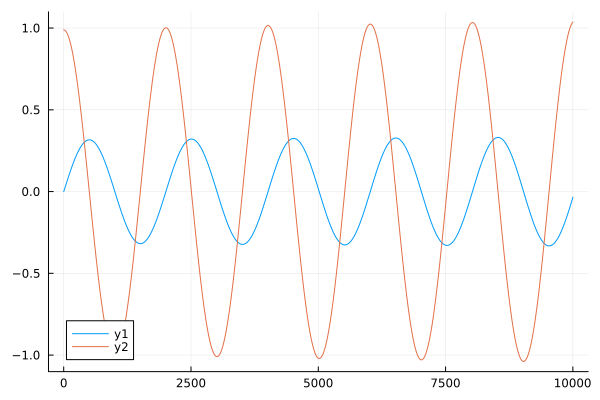

In [10]:
plot(x_smooth)
plot(x_new)

In [5]:
using TimerOutputs
const to = TimerOutput()

function Hessian(l::LDS, y::AbstractArray)
    T, _ = size(y)
    inv_R = pinv(l.R)
    inv_Q = pinv(l.Q)
    inv_p0 = pinv(l.p0)

    # Time precomputation separately
    @timeit to "Inverses" begin
        inv_R = pinv(l.R)
        inv_Q = pinv(l.Q)
        inv_p0 = pinv(l.p0)
    end

    # Time super and sub diagonal computations
    @timeit to "Diagonal Setup" begin
        H_sub_entry = inv_Q * l.A
        H_super_entry = Matrix(H_sub_entry')
        H_sub = Vector{typeof(H_sub_entry)}(undef, T-1)
        H_super = Vector{typeof(H_super_entry)}(undef, T-1)
    end

    # Time the threaded loop for sub and super diagonal filling
    @timeit to "Sub and Super Diagonal Filling" begin
        Threads.@threads for i in 1:T-1
            H_sub[i] = H_sub_entry
            H_super[i] = H_super_entry
        end
    end

    # Time the main diagonal computations
    yt_given_xt = - l.H' * inv_R * l.H
    xt_given_xt_1 = - inv_Q
    xt1_given_xt = - l.A' * inv_Q * l.A
    x_t = - inv_p0
    H_diag = Vector{typeof(yt_given_xt)}(undef, T)

    @timeit to "Main Diagonal Filling" begin
        Threads.@threads for i in 2:T-1
            H_diag[i] = yt_given_xt + xt_given_xt_1 + xt1_given_xt
        end
    end

    # Time edge cases
    @timeit to "Edge Cases" begin
        H_diag[1] = yt_given_xt + xt1_given_xt + x_t
        H_diag[T] = yt_given_xt + xt_given_xt_1
    end

    # Time the final assembly
    @timeit to "Assembly" return block_tridgm(H_diag, H_super, H_sub)
end

Hessian(kf, x_noisy')
# Show the timings
show(to)

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            1.48s /   9.7%           91.1MiB /  14.6%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 Main Diagonal Filling      1   76.5ms   53.2%  76.5ms   2.44MiB   18.3%  2.44MiB
 Sub and Super Diag...      1   37.0ms   25.7%  37.0ms   1.11MiB    8.3%  1.11MiB
 Assembly                   1   30.4ms   21.1%  30.4ms   9.60MiB   72.2%  9.60MiB
 Diagonal Setup             1   42.4μs    0.0%  42.4μs    157KiB    1.1%   157KiB
 Edge Cases                 1   11.7μs    0.0%  11.7μs      208B    0.0%     208B
 Inverses                   1   6.50μs    0.0%  6.50μs      960B    0.0%     960B
 ──────────────

In [6]:
G = SSM.Gradient(kf, x_noisy',  x_prediction)

10001×2 Matrix{Float64}:
  0.0        0.0
  2.05496   -0.154215
 -1.31503   -0.450251
 -1.91532    0.229046
 -1.82399    0.548915
  3.89587    2.29797
 -6.11194   -1.59967
 -0.524136   1.72295
 -0.618485   0.336781
  1.36062   -1.61437
  ⋮         
  1.13277   -0.626463
  3.4012    -1.79944
  0.30317    0.102463
 -0.537875   0.160489
  3.16551   -0.0932142
  3.56852    1.45142
 -0.888484   1.85597
  2.64423    4.92109
 -0.360793   2.90734

In [2]:
# need to use previously aquired pendulum data for comparison
pendulum_data = CSV.read("/Users/ryansenne/Documents/GitHub/SSM/notebooks/pendulum_data_1.csv", DataFrame)

# convert x_noisy columns to matrix for use 
x_noisy =  Matrix(pendulum_data[1:1000, 3:4])

# now create a Kalman Filter where we want to learn the parameters
A = [1 0.001; 0.1 1]
H = [1 0.0; 0.0 1]
Q = 1e-8 * I(2)
R = 0.25 * I(2)
p0 = 1e-2 * I(2)
x0 = [0.0, 1.0]

# kf = LDS(A, Matrix{Float64}(H), nothing, Matrix{Float64}(Q), Matrix{Float64}(R), x0, Matrix{Float64}(P0), nothing, 2, 2, "Gaussian", Vector([true, true, false, true, true, true, true, false]))
kf_unknown = LDS(A, H, nothing, Q, R, x0, p0, nothing, 2, 2, [false, false, true, false, false, false, false])
# SSM.pca_init!(kf_unknown, x_noisy)

SSM.KalmanFilterEM!(kf_unknown, Matrix{Float64}(x_noisy), 100)

Marginal Log-likelihood at iteration 1: -1978.9965578924744
Marginal Log-likelihood at iteration 2: -1976.8541076648062
Marginal Log-likelihood at iteration 3: -1974.6849338767445
Marginal Log-likelihood at iteration 4: -1972.488528988702
Marginal Log-likelihood at iteration 5: -1970.2643749498795
Marginal Log-likelihood at iteration 6: -1968.0119431103249
Marginal Log-likelihood at iteration 7: -1965.7306941505228
Marginal Log-likelihood at iteration 8: -1963.4200780304052
Marginal Log-likelihood at iteration 9: -1961.0795339617646
Marginal Log-likelihood at iteration 10: -1958.708490405609
Marginal Log-likelihood at iteration 11: -1956.3063650987565
Marginal Log-likelihood at iteration 12: -1953.8725651128543
Marginal Log-likelihood at iteration 13: -1951.406486950165
Marginal Log-likelihood at iteration 14: -1948.907516679822
Marginal Log-likelihood at iteration 15: -1946.375030120204
Marginal Log-likelihood at iteration 16: -1943.808393071678
Marginal Log-likelihood at iteration 17

(LDS([1.000038982952801 -5.496301436728866e-6; 0.09932760902473436 1.0000097133950727], [1.0 0.0; 0.0 1.0], nothing, [1.0e-8 0.0; 0.0 1.0e-8], [0.25 0.0; 0.0 0.25], [0.0, 1.0], [0.01 0.0; 0.0 0.01], nothing, 2, 2, Bool[0, 0, 1, 0, 0, 0, 0]), -1618.8476264607439)

In [19]:
using LinearAlgebra

function block_tridiagonal_inverse(A, B, C)
    n = length(B)
    block_size = size(B[1], 1)

    # Initialize Di and Ei arrays
    D = Array{AbstractMatrix}(undef, n+1)
    E = Array{AbstractMatrix}(undef, n+1)
    λii = Array{AbstractMatrix}(undef, n)

    # Add a zero matrix to the subdiagonal and superdiagonal
    pushfirst!(A, zeros(block_size, block_size))
    push!(C, zeros(block_size, block_size))
    
    # Initial conditions
    D[1] = zeros(block_size, block_size)
    E[n+1] = zeros(block_size, block_size)
 
    # Forward sweep for D
    for i in 1:n
        D[i+1] = inv(B[i] - A[i] * D[i]) * C[i]
    end
  
    # Backward sweep for E
    for i in n:-1:1
        E[i] = inv(B[i] - C[i]*E[i+1]) * A[i]
    end

    # Compute the inverses of the diagonal blocks λii
    for i in 1:n
        term1 = (I - E[i+1]*D[i+1])
        term2 = (B[i] - A[i]*D[i])
        λii[i] = inv(term1)*inv(term2)
    end

    return λii
end



block_tridiagonal_inverse (generic function with 1 method)

In [18]:
A = [[1 2; 3 4], [4 3; 2 1]]
B = [[1 2; 3 4], [4 3; 2 1], [1 2; 3 4]]
C = [[1 2; 3 4], [4 3; 2 1]]

block_tridiagonal_inverse(A, B, C)

[[0 0; 0 0], [1 2; 3 4], [4 3; 2 1]]
[[1 2; 3 4], [4 3; 2 1], [0 0; 0 0]]
VictoryVictory

3-element Vector{AbstractMatrix}:
 [-2.1666666666666647 1.4999999999999991; 1.8333333333333315 -1.1666666666666659]
 [-0.16666666666666696 0.5000000000000003; 0.3333333333333339 -0.6666666666666675]
 [-0.4999999999999999 -0.16666666666666663; 0.16666666666666663 0.5]

In [22]:
mat = [1 2 1 2 0 0; 
       3 4 3 4 0 0; 
       1 2 4 3 4 3; 
       3 4 2 1 2 1; 
       0 0 4 3 1 2; 
       0 0 2 1 3 4]

    inv(mat)

6×6 Matrix{Float64}:
 -2.16667    1.5        0.166667  -0.5       -0.666667   0.333333
  1.83333   -1.16667   -0.333333   0.666667   0.5       -0.166667
  0.166667  -0.5       -0.166667   0.5        0.666667  -0.333333
 -0.333333   0.666667   0.333333  -0.666667  -0.5        0.166667
 -0.666667   0.333333   0.666667  -0.333333  -0.5       -0.166667
  0.5       -0.166667  -0.5        0.166667   0.166667   0.5

In [22]:
inv(Matrix(mat))

6×6 Matrix{Float64}:
 -2.16667    1.5        0.166667  -0.5       -0.666667   0.333333
  1.83333   -1.16667   -0.333333   0.666667   0.5       -0.166667
  0.166667  -0.5       -0.166667   0.5        0.666667  -0.333333
 -0.333333   0.666667   0.333333  -0.666667  -0.5        0.166667
 -0.666667   0.333333   0.666667  -0.333333  -0.5       -0.166667
  0.5       -0.166667  -0.5        0.166667   0.166667   0.5